In [1]:
import numpy as np
from matplotlib import pyplot as plt

from scipy import ndimage
from scipy import misc
from my_utils import *

In [2]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams["figure.figsize"] = (11,8)

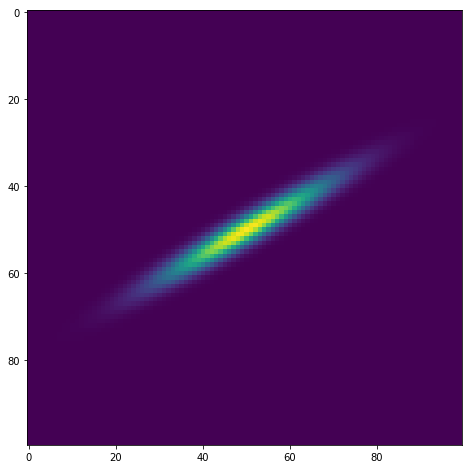

In [3]:
# define normalized 2D gaussian
def gaus2d_phi(x=0, y=0, mx=0, my=0, sx=1, sy=1,phi=0):
  cos_phi = np.cos(phi)
  sin_phi = np.sin(phi)
  sin_2phi = np.sin(2*phi)
  cos2_phi = cos_phi*cos_phi
  sin2_phi = sin_phi*sin_phi

  a= (cos2_phi)/(2.*sx**2.) + (sin2_phi)/(2.*sy**2.)
  b= -(sin_2phi)/(4.*sx**2.) + (sin_2phi)/(4.*sy**2.)
  c= (sin2_phi)/(2.*sx**2.) + (cos2_phi)/(2.*sy**2.)
    
  return (1. / (2. * np.pi * sx * sy) * np.exp(-(a*(x - mx)**2.+ 2.*b*(x - mx)*(y - my)  + c*(y - my)**2. )))

size_x = 100
size_y = 100    

mesh_x = range(0,size_x)
mesh_y = range(0,size_y)
mesh_x, mesh_y = np.meshgrid(mesh_x,mesh_y)

plt.imshow(gaus2d_phi(mesh_x,mesh_y,50,50,15,2,np.pi/6))



    

In [4]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
plt.rcParams["figure.figsize"] = (11,8)

(256, 256, 3)
(256, 256, 4)


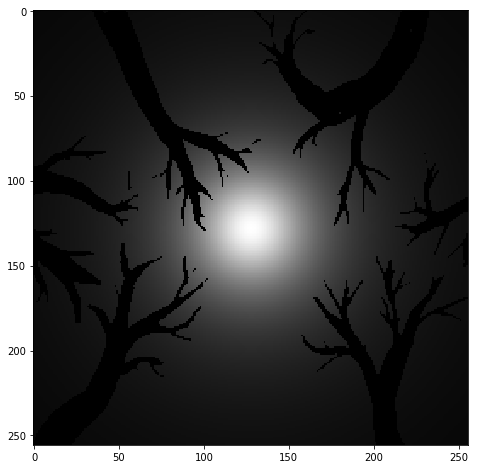

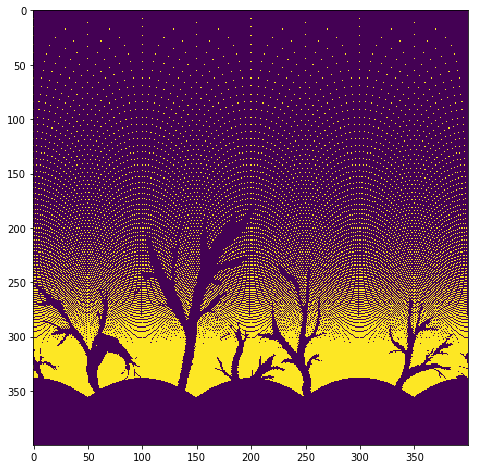

In [5]:
r_dome = 0.1 # m
d_ceil = 0.5 # m
ceil_screen_size = 4.0 # m
pixels = 256
light_sigma = 2e-3

screen = np.zeros((pixels,pixels,3))
print(np.shape(screen))
offset_x = 0
offset_y = 0
#image = misc.imread("branches.png")[offset_y:offset_y+pixels,offset_x:offset_x+pixels]
image = misc.imread("johannes.png")[offset_y:offset_y+pixels,offset_x:offset_x+pixels]
image = ((image>80))*1.000

pix_to_m = 1./pixels*ceil_screen_size
d_ceil_sqr = float(d_ceil)*float(d_ceil)


theta_pixels = 400
phi_pixels = 400

shaded_image = np.zeros((pixels,pixels))
dome_matrix = np.zeros((theta_pixels,phi_pixels))

for i in range(0,pixels):
    for j in range(0,pixels):
        y = -(i-pixels/2)*pix_to_m
        x = (j-pixels/2)*pix_to_m
        dist = np.sqrt(x*x + y*y + d_ceil_sqr)
        r = np.sqrt(x*x+y*y)
        if r == 0:
            r = 1e-3
        phi = np.arctan2(y,x)
        
        if (phi < 0):
          phi = 2*np.pi + phi
        
        theta = np.arctan2(r,d_ceil)
        if np.isnan(theta):
            theta = 0
            
        theta_index = int(theta/(np.pi/2.)*theta_pixels)
        phi_index   = int(phi/(2*np.pi)*phi_pixels)
        dome_matrix[theta_index,phi_index] = image[i,j,0]
        
        # shading
        shaded_image[i,j] = image[i,j,0] * 1/((dist*dist)/(d_ceil_sqr))

for i in range(0,3):
  screen[:,:,i] = shaded_image

print(np.shape(image))
plt.imshow(screen)
plt.show()

plt.imshow(dome_matrix)
plt.show()

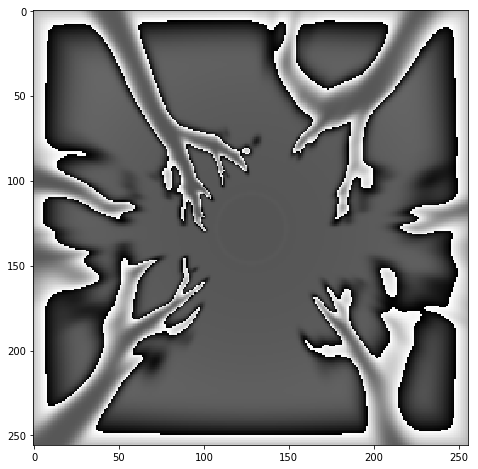

In [6]:
smeared_image = np.zeros((pixels,pixels))

mesh_x = range(0,pixels)
mesh_y = range(0,pixels)
mesh_x, mesh_y = np.meshgrid(mesh_x,mesh_y)


for i in range(0,pixels):
    for j in range(0,pixels):
        y = -(i-pixels/2)*pix_to_m
        x = (j-pixels/2)*pix_to_m
        dist = np.sqrt(x*x + y*y + d_ceil_sqr)
        r = np.sqrt(x*x+y*y)
        if r == 0:
            r = 1e-3
        phi = np.arctan2(y,x)
        
        if (phi < 0):
          phi = 2*np.pi + phi
        
        theta = np.arctan2(r,d_ceil)
        if np.isnan(theta):
            theta = 0
            
        # shading_factor
        shading = 1.0/((dist*dist)/(d_ceil_sqr))
        
        smear_sigma = (dist-r_dome)/r_dome * light_sigma
        smear_r     = smear_sigma * 1/(np.cos(theta)) 
        
        smear_sigma_pix = smear_sigma /pix_to_m
        smear_r_pix = smear_r /pix_to_m
        
        if smear_sigma_pix < 0.75:
            smear_sigma_pix = 0.75
        if smear_r_pix < 0.75:
            smear_r_pix = 0.75
        
        smeared_image += 1*shading + image[i,j,0] * gaus2d_phi(mesh_x,mesh_y,j,i,smear_r_pix,smear_sigma_pix,phi)

#smeared_image /= np.max(smeared_image)        
for i in range(0,3):
  screen[:,:,i] = smeared_image

plt.imshow(screen)
plt.show()

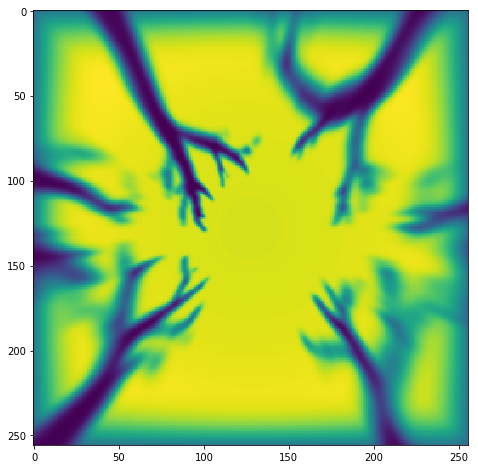

In [7]:

plt.imshow(smeared_image)
plt.show()

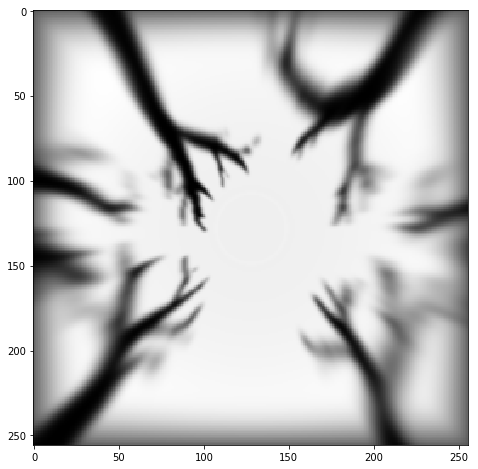

In [8]:
#plt.imshow(smeared_image)
smeared_image -= np.min(smeared_image)
smeared_image /= np.max(smeared_image)        
for i in range(0,3):
  screen[:,:,i] = smeared_image

plt.imshow(screen)
plt.show()
